In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from textblob import TextBlob
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)
cf.go_offline();
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

pd.set_option('display.max_columns', None)


In [ ]:
df = pd.read_csv("/content/amazon.csv")

In [ ]:
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4,No issues.,23-07-2014,138,0,0,0,0,0.0,0.0
1,1,0mie,5,"Purchased this for my device, it worked as adv...",25-10-2013,409,0,0,0,0,0.0,0.0
2,2,1K3,4,it works as expected. I should have sprung for...,23-12-2012,715,0,0,0,0,0.0,0.0
3,3,1m2,5,This think has worked out great.Had a diff. br...,21-11-2013,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5,"Bought it with Retail Packaging, arrived legit...",13-07-2013,513,0,0,0,0,0.0,0.0


In [ ]:
df = df.sort_values("wilson_lower_bound", ascending = False)
df.drop( 'Unnamed: 0', inplace = True, axis=1)
df.head()

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,"Hyoun Kim ""Faluzure""",5,[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544
3449,NLee the Engineer,5,I have tested dozens of SDHC and micro-SDHC ca...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519
4212,SkincareCEO,1,NOTE: please read the last update (scroll to ...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139
317,"Amazon Customer ""Kelly""",1,"If your card gets hot enough to be painful, it...",09-02-2012,1033,422,73,495,349,0.852525,0.818577
4672,Twister,5,Sandisk announcement of the first 128GB micro ...,03-07-2014,158,45,4,49,41,0.918367,0.808109


In [ ]:
def missing_values_analysis(df) :
  na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
  n_miss = df[na_columns_].isnull().sum().sort_values(ascending=True)
  ratio_ =(df[na_columns_].isnull().sum()/df.shape[0]* 100).sort_values(ascending=True)
  missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys = ['Missing Values', 'Ratio'])
  missing_df = pd.DataFrame(missing_df)
  return missing_df

def check_dataframe(df, head= 5, tail= 5) :

  print ("SHAPE".center(82,"~"))
  print('Rows:{}'.format (df.shape[0]))
  print("columns:{}".format(df.shape[1]))
  print("TYPES".center(82,"~"))
  print(df.dtypes)
  print("".center(82,"~"))
  print(missing_values_analysis(df))
  print('DUPLICATED VALUES'.center(83, "~"))
  print(df.duplicated().sum())
  print ("QUANTILES".center(82,'~'))
  print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_dataframe(df)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows:4915
columns:11
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
reviewerName             object
overall                   int64
reviewText               object
reviewTime               object
day_diff                  int64
helpful_yes               int64
helpful_no                int64
total_vote                int64
score_pos_neg_diff        int64
score_average_rating    float64
wilson_lower_bound      float64
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              Missing Values  Ratio
reviewerName               1   0.02
reviewText                 1   0.02
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~DUPLICATED VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~QUANTILES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                       0.00  0.05   0.50        0.95       0.99         1.00
overall   

In [ ]:
def check_class(dataframe):
  nunique_df = pd.DataFrame({'Variable': dataframe.columns,
                             'Classes' : [dataframe[i].nunique() for i in dataframe.columns]})
  nunique_df = nunique_df.sort_values('Classes',ascending = False)
  nunique_df = nunique_df.reset_index(drop = True)
  return nunique_df

check_class(df)





,Variable,Classes
0,reviewText,4912
1,reviewerName,4594
2,reviewTime,690
3,day_diff,690
4,wilson_lower_bound,40
5,score_average_rating,28
6,score_pos_neg_diff,27
7,total_vote,26
8,helpful_yes,23
9,helpful_no,17


In [ ]:
constraints = ['#B34D22', '#EBE00C', '#1FEB0C' ,'#0C92EB','#EBOCD5']
def categorical_variable_summary(df, column_name):
  fig = make_subplots(rows = 1, cols =2,
                    subplot_titles= ('Countplot', 'Percentage'),
                    specs=[[{"types": "xy"}, {'types': 'domain'}]])

  fig.add_trace(go.Bar( y = df[column_name].value_counts().values.tolist(),
                        x = [str(i) for i in df[column_name].value_counts().index],
                        text=df[column_name].value_counts().values.tolist(),
                        textfont = dict(size=14),
                        name=column_name,
                        textposition = 'auto',
                      showlegend=False,
                        marker= dict (color = constraints,line= dict(color='#DBE6EC',width =1))),
                        row=1, col = 1)
  fig.add_trace(go.Pie(labels = df[column_name].value_counts().keys(),
                          values= df[column_name]. value_counts ().values,
                          textfont=dict(size = 18),
                          textposition= 'auto',
                          showlegend= False,
                          name=column_name,
                          marker = dict (colors = constraints)),
                          row=1, col=2)
  fig.update_layout(title={'text': column_name,
                            'y': 0.9,
                            'x': 0.5,
                            'xanchor': 'center',
                            'yanchor': 'top'},
                            template = 'plotly_white')

  iplot(fig)

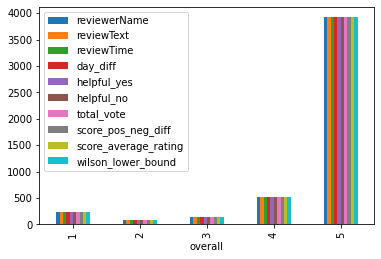

In [ ]:
df.groupby('overall').count().plot(kind='bar')


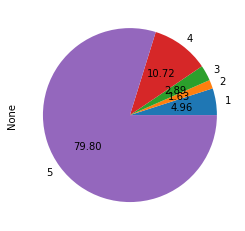

In [ ]:
df.groupby('overall').size().plot(kind='pie', autopct ='%.2f')

In [ ]:
df.reviewText.head()

2031    [[ UPDATE - 6/19/2014 ]]So my lovely wife boug...
3449    I have tested dozens of SDHC and micro-SDHC ca...
4212    NOTE:  please read the last update (scroll to ...
317     If your card gets hot enough to be painful, it...
4672    Sandisk announcement of the first 128GB micro ...
Name: reviewText, dtype: object

In [ ]:
review_example = df.reviewText[2031]
review_example

'[[ UPDATE - 6/19/2014 ]]So my lovely wife bought me a Samsung Galaxy Tab 4 for Father\'s Day and I\'ve been loving it ever since.  Just as other with Samsung products, the Galaxy Tab 4 has the ability to add a microSD card to expand the memory on the device.  Since it\'s been over a year, I decided to do some more research to see if SanDisk offered anything new.  As of 6/19/2014, their product lineup for microSD cards from worst to best (performance-wise) are the as follows:SanDiskSanDisk UltraSanDisk Ultra PLUSSanDisk ExtremeSanDisk Extreme PLUSSanDisk Extreme PRONow, the difference between all of these cards are simply the speed in which you can read/write data to the card.  Yes, the published rating of most all these cards (except the SanDisk regular) are Class 10/UHS-I but that\'s just a rating... Actual real world performance does get better with each model, but with faster cards come more expensive prices.  Since Amazon doesn\'t carry the Ultra PLUS model of microSD card, I had 

In [ ]:
review_example=re.sub("[^a-zA-Z]", '', review_example)
review_example


'UPDATESomylovelywifeboughtmeaSamsungGalaxyTabforFathersDayandIvebeenlovingiteversinceJustasotherwithSamsungproductstheGalaxyTabhastheabilitytoaddamicroSDcardtoexpandthememoryonthedeviceSinceitsbeenoverayearIdecidedtodosomemoreresearchtoseeifSanDiskofferedanythingnewAsoftheirproductlineupformicroSDcardsfromworsttobestperformancewisearetheasfollowsSanDiskSanDiskUltraSanDiskUltraPLUSSanDiskExtremeSanDiskExtremePLUSSanDiskExtremePRONowthedifferencebetweenallofthesecardsaresimplythespeedinwhichyoucanreadwritedatatothecardYesthepublishedratingofmostallthesecardsexcepttheSanDiskregularareClassUHSIbutthatsjustaratingActualrealworldperformancedoesgetbetterwitheachmodelbutwithfastercardscomemoreexpensivepricesSinceAmazondoesntcarrytheUltraPLUSmodelofmicroSDcardIhadtododirectcomparisonsbetweentheSanDiskUltraExtremeandExtremePLUSAsmentionedinmyearlierreviewIpurchasedtheSanDiskUltraformyGalaxySMyquestionwasdidIwanttopayovermoreforacardthatisfasterthantheoneIalreadyownedOrIcouldpayalmostdoubletoget

In [ ]:
def data():
  data['reviewText'] = data['reviewText'].str.lower()
  return data()

In [ ]:
rt = lambda x : re.sub("[^a-zA-Z]", '', str(x))
df["reviewText"] = df["reviewText"].map(rt)
df["reviewText"] = df["reviewText"].str.lower()
df.head()


,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,"Hyoun Kim ""Faluzure""",5,updatesomylovelywifeboughtmeasamsunggalaxytabf...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544
3449,NLee the Engineer,5,ihavetesteddozensofsdhcandmicrosdhccardsonedis...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519
4212,SkincareCEO,1,notepleasereadthelastupdatescrolltothebottomim...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139
317,"Amazon Customer ""Kelly""",1,ifyourcardgetshotenoughtobepainfulitisdefectiv...,09-02-2012,1033,422,73,495,349,0.852525,0.818577
4672,Twister,5,sandiskannouncementofthefirstgbmicrosdtookinte...,03-07-2014,158,45,4,49,41,0.918367,0.808109


In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 7.6 MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
df[['polarity', 'subjectivity']] = df['reviewText'].apply(lambda Text : pd.Series(TextBlob(Text).sentiment))

for index, row in df['reviewText'].iteritems():

  score = SentimentIntensityAnalyzer().polarity_scores(row)

  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  if neg >pos :
    df.loc[index, 'sentiment'] = "Negative"
  elif pos > neg :
    df.loc[index, 'sentiment'] = "Positive"
  else :
    df.loc[index, 'sentiment'] = "Neutral"

In [ ]:
df[df["sentiment"] == "Positive"].sort_values("wilson_lower_bound", ascending = False). head(5)


,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,polarity,subjectivity,sentiment
3234,minh thong cao,5,good,07-07-2014,154,0,0,0,0,0.0,0.0,0.700000,0.600000,Positive
3605,peter Metcalf,5,perfect,07-02-2014,304,0,0,0,0,0.0,0.0,1.000000,1.000000,Positive
4308,Stephane Gauthier,5,super,15-02-2013,661,0,0,0,0,0.0,0.0,0.333333,0.666667,Positive
3741,RASHAWN,5,great,07-12-2014,1,0,0,0,0,0.0,0.0,0.800000,0.750000,Positive
705,Brandon Warren,5,yes,14-07-2014,147,0,0,0,0,0.0,0.0,0.000000,0.000000,Positive


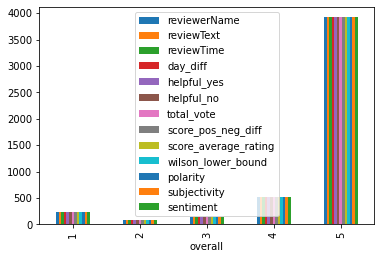

In [ ]:
df.groupby('overall').count().plot(kind='bar')



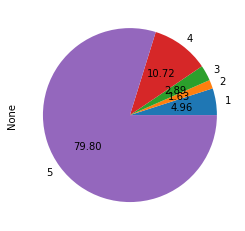

In [ ]:
df.groupby('overall').size().plot(kind='pie', autopct ='%.2f')